<a href="https://colab.research.google.com/github/junhye00n/computer-vision/blob/master/MNIST_dataset_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# 빠른 가속을 위해 런타임을 GPU로 변경

In [10]:
!pip3 install torch    # torch 설치
!pip3 install torchvision    # torchvision 설차

In [11]:
from typing import Dict, List    # Dict 및 유형을 가져옴
import torch    # 파이토치 라이브러리를 가져옴
import matplotlib.pyplot as plt    # 시각화 작업에 필요한 pyplot 모듈을 라이브러리에서 가져옴
from torch import Tensor, nn, optim    # 파이토치 라이브러리에서 특정 클래스를 가져옴
from torch.utils.data import Dataset, DataLoader    # dataset 클래스를 가져옴
from torchvision import datasets    # datasets 모듈을 가져온다(이미지 분류 작업에 사용되는 데이터셋들)
from torchvision.transforms import ToTensor    # 이미지 또는 넘파이 배열을 파이토치 텐서로 변환하기 위해 클래스 가져옴

_Optimizer = torch.optim.Optimizer    # 클래스의 명칭을 만듦

In [12]:
# 학습에 사용할 모델 정의
class MNISTNetwork(nn.Module):    # MNISTNetwork 클래스 정의
    def __init__(self) -> None:
        super(MNISTNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(    # 세 개의 층으로 정의, 각 층 뒤에는 할성화함수로 ReLU를 사용
            nn.Linear(28 * 28, 512),    # MNIST 이미지 픽셀 수 28x28, 출력은 784 중에 512
            nn.ReLU(),    # 첫 번째 층의 ReLU 활성화 함수
            nn.Linear(512, 512),    # 두 번째 선형 층(입력의 512를 다시 512 차원으로 변환)
            nn.ReLU(),    # 두 번째 층의 ReLU 함수 정의
            nn.Linear(512, 10),    # 세 번째 선형 층(입력의 512를 MNIST 0~9의 클래스 10개로 10개의 출력)
        )

    def forward(self, x: Tensor) -> Tensor:    # 파이토치의 모델 클래스의 forward 메서드를 정의하는 정의식
        x = self.flatten(x)    # 입력 데이터 x를 self.flatten에 전달하여 평탄화
        logits = self.linear_relu_stack(x)    # 평탄화 된 x를 self.linear_relu_stack에 전달
        return logits    # 최종 로짓 반환

In [13]:
# 학습 코드
def train(
    dataloader: DataLoader,
    device: str,
    model: nn.Module,
    loss_fn: nn.Module,
    optimizer: _Optimizer,
) -> None:
    size = len(dataloader.dataset)
    model.train()    # 모델 학습

    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):    # 미니배치를 가져와서 학습
        X, y = X.to(device), y.to(device)    # 지정 device로 가져옴

        pred = model(X)    # 모델에 입력 데이터 전달 예측
        loss = loss_fn(pred, y)    # 손실함수 사용하여 예측과 실제 손실 차이 계산

        optimizer.zero_grad()    # 그래디언트 초기화
        loss.backward()    # 역전파 수행
        optimizer.step()    # 가중치 업데이트

        if batch % 100 == 0:    # 100번 째 미니배치일 때 수행할 것
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>5f}  [{current:>5d}/{size:>5d}]")    #현재 손실 함수를 출력하여 확인

        train_loss += loss    # 미니배치 손실을 전체 학습에 누적

    return train_loss / size    # 전체 학습 손실을 전체 크기로 나눠서 평균 손실 계산


In [14]:
# 테스트 코드
def test(
    dataloader: DataLoader, device: str, model: nn.Module, loss_fn: nn.Module
) -> None:
    size = len(dataloader.dataset)    # 테스트 데이터셋 크기 설정
    num_batches = len(dataloader)    # 미니배치 수 설정
    model.eval()    # 모델을 test 용도로 설정
    test_loss = 0    # 손실 값 초기화
    correct = 0    # 정확도 초기화
    with torch.no_grad():    # 그래디언트 계산 비활성화 시킴(테스트 과정이기에 안해도 됨)
        for X, y in dataloader:    # 각 미니배치에 대한 반복문 실행
            X, y = X.to(device), y.to(device)    # 각 데이터와 레이블을 디정된 device로 이동
            pred = model(X)    # 모델에 입력 데이터 전달해서 예측
            test_loss += loss_fn(pred, y).item()    # 손실함수로 예측과 실제 계산 값 손실 계산
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()    # 정확한 예측의 수 누적
    test_loss /= num_batches    # 전체 테스트 손실하고 정확도를 계산
    correct /= size    # 정확도를 테스트 사이즈로 나눠서 출력문 작성
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>3f} \n"    # 퍼센트 화,소숫점 반올림 자리 설정
    )

In [15]:
# 추론 코드
def predict(test_data: Dataset, model: nn.Module) -> None:
    model.eval()    # 모델을 평가 모드로
    x = test_data[0][0]    # 데이터 셋에서 0,0 첫 번째 포인트 가져오기
    y = test_data[0][1]
    with torch.no_grad():    # 추론 과정에서의 그래디언트 과정 제외
        pred = model(x)    # 모델에 데이터 전달하여 추론
        predicted, actual = pred[0].argmax(0), y    # 모델 출력에서 예측값과 실제값 가져오기
        print(f"Predicted: {predicted}, Actual: {actual}")    # 예측값과 실제값 출력

Epoch 1

********************************
loss: 2.300557  [    0/60000]
loss: 0.752071  [12800/60000]
loss: 0.343454  [25600/60000]
loss: 0.324884  [38400/60000]
loss: 0.415535  [51200/60000]
Test Error: 
 Accuracy: 90.9%, Avg loss: 0.310524 

Epoch 2

********************************
loss: 0.243741  [    0/60000]
loss: 0.203984  [12800/60000]
loss: 0.228246  [25600/60000]
loss: 0.212922  [38400/60000]
loss: 0.264160  [51200/60000]
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.227547 

Epoch 3

********************************
loss: 0.158998  [    0/60000]
loss: 0.141120  [12800/60000]
loss: 0.193357  [25600/60000]
loss: 0.154640  [38400/60000]
loss: 0.200437  [51200/60000]
Test Error: 
 Accuracy: 95.0%, Avg loss: 0.166259 

Epoch 4

********************************
loss: 0.111131  [    0/60000]
loss: 0.099478  [12800/60000]
loss: 0.158898  [25600/60000]
loss: 0.128429  [38400/60000]
loss: 0.168851  [51200/60000]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.133481 

Epoch 5

***************

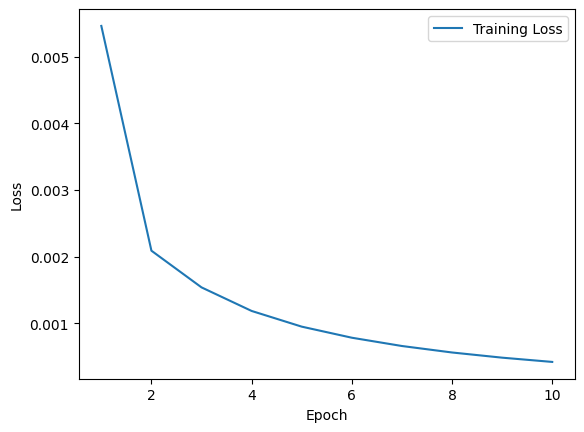

In [19]:
# 학습과 테스트 실행하는 코드
def run_pytorch(batch_size: int, epochs: int) -> None:    # 배치 사이즈와 epoch는 정수로
    # 데이터 불러오기
    training_data = datasets.MNIST(    # MNIST 데이터셋 불러오기
        root="data",    # 데이터 저장경로
        train=True,    # 훈련 진행
        download=True,    # 데이터가 없다면 다운로드 진행
        transform=ToTensor(),    # 이미지를 파이토치 텐서로 변환시킴
    )

    test_data = datasets.MNIST(    # MNIST 데이터셋 불러오기
        root="data",    # 데이터 저장경로
        train=False,    # 훈련 안함 테스트 과정이기 때문에
        download=True,    # 데이터가 없다면 다운로드 진행
        transform=ToTensor(),    # 이미지를 파이토치 텐서로 변환시킴
    )

    train_dataloader = DataLoader(training_data, batch_size=batch_size)    #  학습 데이터와 배치 단위를 나눠서 데이토 로드
    test_dataloader = DataLoader(test_data, batch_size=batch_size)    # 테스트 데이터를 배치크기를 정해서 데이터 로드

    device = "cuda" if torch.cuda.is_available() else "cpu"    # 쿠다있으면 사용하고 없으면 cpu 현재는 코랩에서 GPU 사용

    model = MNISTNetwork().to(device)

    loss_fn = nn.CrossEntropyLoss()    # 다중 클래스 분류에서 사용되는 손실함수 정의
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)    # 학습률을 0.01, 모멘텀은 0.9

    epoch_loss = []    # 에복 리스트 초기화
    # 학습과 테스트 에폭
    for t in range(epochs):
        print(f"Epoch {t+1}\n\n********************************")
        train_loss = train(train_dataloader, device, model, loss_fn, optimizer)    # 훈련 함수를 호출하여 모델 학습
        epoch_loss.append(train_loss.detach().cpu().numpy())    # 훈련 손실을 아까 초기화한 리스트에 추가<<배열 형태로
        test(test_dataloader, device, model, loss_fn)    # 테스트 함수로 모델 평가

    model = MNISTNetwork()    # 인스턴스 생성
    predict(test_data, model)    # 테스트 데이터에 대한 결과치 예측

    plt.plot(range(1, epochs + 1), epoch_loss, label="Training Loss")
    plt.xlabel("Epoch")    # 에폭으로 x축 라벨링
    plt.ylabel("Loss")    # 손실로 y축 라벨링
    plt.legend()    # 범례 추가
    plt.show()    # 함수 보여주기


if __name__ == "__main__":
    run_pytorch(batch_size=128, epochs=10)    # 배치 사이즈와 에폭을 지정해서 출력
